In [1]:
# Cell 1: 安装必要的包
"""
这个单元格用于安装必要的Python包。
如果您的环境中没有这些包，请取消注释下面的pip安装命令。
"""

# 请确保已安装以下包，如果没有，可以运行：
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install scikit-learn matplotlib numpy pandas tqdm opencv-python pillow
%pip install timm  

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 2: 导入必要的库和模块
"""
导入所有必要的Python库。
这个单元格包含了我们将要使用的所有库和模块。
"""

import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# 设置中文字体支持 - 修复方框问题
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 中文字体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
print("中文字体设置完成")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, roc_auc_score,
                            confusion_matrix, classification_report)

# 深度学习相关库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet18, ResNet18_Weights
import cv2
from PIL import Image

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("所有必要的库已导入")
print(f"PyTorch版本: {torch.__version__}")

中文字体设置完成
所有必要的库已导入
PyTorch版本: 2.2.0+cpu


In [3]:
# Cell 3: 数据加载器和数据集类定义 (最终修正版)
"""
定义自定义数据集类和数据处理流程。
这个单元格包含了加载和预处理图像数据的所有功能。
"""

import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, roc_auc_score,
                            confusion_matrix, classification_report)

# 深度学习相关库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet18, ResNet18_Weights
import cv2
from PIL import Image

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("所有必要的库已导入")
print(f"PyTorch版本: {torch.__version__}")

class AnomalyDetectionDataset(Dataset):
    """自定义数据集类，用于加载和预处理图像"""
    
    def __init__(self, root_dir, categories, split='train', transform=None, 
                 use_json_labels=False, json_path=None):
        """
        初始化数据集
        
        参数:
            root_dir: 数据集根目录（应该是当前目录'.'）
            categories: 类别列表，如 ['hazelnut', 'zipper']
            split: 数据集划分，'train' 或 'test'
            transform: 图像变换
            use_json_labels: 是否使用JSON文件中的标签
            json_path: JSON文件路径
        """
        self.root_dir = root_dir
        self.categories = categories
        self.split = split
        self.transform = transform
        self.samples = []
        self.labels = []
        self.image_paths = []  # 保存图像路径
        self.category_list = []  # 保存类别信息
        
        # 如果提供了JSON文件路径且是测试集，从JSON加载标签
        if use_json_labels and json_path and os.path.exists(json_path) and split == 'test':
            print(f"从JSON文件加载{split}数据...")
            self._load_test_from_json(json_path)
        else:
            # 从文件夹结构加载
            print(f"从文件夹加载{split}数据...")
            self._load_from_folders()
    
    def _load_test_from_json(self, json_path):
        """从JSON文件加载测试数据"""
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        loaded_count = 0
        for img_path, info in data.items():
            # 解析路径
            parts = img_path.split('/')
            if len(parts) >= 2:
                category = parts[0]
                split_type = parts[1] if len(parts) > 1 else ''
                
                # 检查是否属于指定的类别和test划分
                if category in self.categories and split_type == 'test':
                    # 构建完整的图像路径（相对于当前目录）
                    full_path = os.path.join(self.root_dir, img_path)
                    
                    # 检查文件是否存在
                    if os.path.exists(full_path):
                        # 获取标签
                        label = 0 if info['label'] == 'good' else 1
                        self.samples.append(full_path)
                        self.labels.append(label)
                        self.category_list.append(category)
                        self.image_paths.append(img_path)
                        loaded_count += 1
                    else:
                        # 尝试另一种路径格式（使用os.path.join）
                        alt_path = os.path.join(*img_path.split('/'))
                        if os.path.exists(alt_path):
                            label = 0 if info['label'] == 'good' else 1
                            self.samples.append(alt_path)
                            self.labels.append(label)
                            self.category_list.append(category)
                            self.image_paths.append(img_path)
                            loaded_count += 1
                        else:
                            print(f"警告: 文件不存在: {full_path} 或 {alt_path}")
        
        print(f"从JSON加载了 {loaded_count} 个测试样本")
    
    def _load_from_folders(self):
        """从文件夹结构加载数据"""
        total_loaded = 0
        
        for category in self.categories:
            # 构建路径
            category_path = os.path.join(self.root_dir, category, self.split)
            
            if not os.path.exists(category_path):
                print(f"警告: 路径不存在: {category_path}")
                continue
            
            # 加载正常样本
            good_path = os.path.join(category_path, 'good')
            if os.path.exists(good_path):
                # 获取所有图像文件
                image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.PNG', '.JPG', '.JPEG']
                good_images = []
                for f in os.listdir(good_path):
                    if any(f.lower().endswith(ext) for ext in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']):
                        good_images.append(f)
                
                for img_name in good_images[:]:  # 使用切片复制，避免修改原列表
                    img_path = os.path.join(good_path, img_name)
                    self.samples.append(img_path)
                    self.labels.append(0)  # 正常样本标签为0
                    self.category_list.append(category)
                    self.image_paths.append(f"{category}/{self.split}/good/{img_name}")
                    total_loaded += 1
                
                print(f"类别 {category} {self.split} 正常样本: {len(good_images)} 张")
            else:
                print(f"警告: 正常样本路径不存在: {good_path}")
            
            # 加载异常样本
            bad_path = os.path.join(category_path, 'bad')
            if os.path.exists(bad_path):
                # 获取所有图像文件
                image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.PNG', '.JPG', '.JPEG']
                bad_images = []
                for f in os.listdir(bad_path):
                    if any(f.lower().endswith(ext) for ext in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']):
                        bad_images.append(f)
                
                for img_name in bad_images[:]:
                    img_path = os.path.join(bad_path, img_name)
                    self.samples.append(img_path)
                    self.labels.append(1)  # 异常样本标签为1
                    self.category_list.append(category)
                    self.image_paths.append(f"{category}/{self.split}/bad/{img_name}")
                    total_loaded += 1
                
                print(f"类别 {category} {self.split} 异常样本: {len(bad_images)} 张")
            else:
                print(f"警告: 异常样本路径不存在: {bad_path}")
        
        print(f"从文件夹加载了 {total_loaded} 个样本，类别: {self.categories}, 划分: {self.split}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]
        
        # 加载图像
        try:
            # 尝试使用PIL加载
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # 如果PIL失败，尝试使用OpenCV
            try:
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = Image.fromarray(image)
                else:
                    # 如果两种方法都失败，返回黑色图像
                    print(f"警告: 无法加载图像 {img_path}: {str(e)}")
                    image = Image.new('RGB', (224, 224), color='black')
            except:
                print(f"严重警告: 完全无法加载图像 {img_path}")
                image = Image.new('RGB', (224, 224), color='black')
        
        # 应用变换
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path
    
    def get_class_distribution(self):
        """获取类别分布"""
        if len(self.labels) == 0:
            return {}
        unique, counts = np.unique(self.labels, return_counts=True)
        return dict(zip(unique, counts))
    
    def get_category_distribution(self):
        """获取类别分布"""
        if len(self.category_list) == 0:
            return {}
        
        from collections import Counter
        return dict(Counter(self.category_list))
    
    def get_category_info(self):
        """获取每个样本的类别信息"""
        return self.category_list


def get_transforms(mode='train', img_size=224):
    """获取图像变换"""
    if mode == 'train':
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    else:  # test/val
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])


def create_data_loaders(root_dir, categories, batch_size=32, 
                        use_json=True, json_path=None, num_workers=0):
    """
    创建训练和测试数据加载器
    
    注意：在Windows上，num_workers应该设置为0以避免多进程问题
    """
    # 定义变换
    train_transform = get_transforms('train')
    test_transform = get_transforms('test')
    
    # 创建训练数据集 - 从文件夹加载
    print("创建训练数据集...")
    train_dataset = AnomalyDetectionDataset(
        root_dir=root_dir,
        categories=categories,
        split='train',
        transform=train_transform,
        use_json_labels=False,  # 训练集从文件夹加载
        json_path=None
    )
    
    # 创建测试数据集 - 从JSON加载标签信息
    print("创建测试数据集...")
    test_dataset = AnomalyDetectionDataset(
        root_dir=root_dir,
        categories=categories,
        split='test',
        transform=test_transform,
        use_json_labels=use_json,  # 测试集可以从JSON加载
        json_path=json_path
    )
    
    # 检查数据集大小
    train_dist = train_dataset.get_class_distribution()
    test_dist = test_dataset.get_class_distribution()
    
    print(f"\n数据集统计:")
    print(f"训练集: {len(train_dataset)} 个样本, 分布: {train_dist}")
    print(f"测试集: {len(test_dataset)} 个样本, 分布: {test_dist}")
    
    # 检查训练集是否为空
    if len(train_dataset) == 0:
        print("\n警告: 训练集为空!")
        print("检查以下路径是否存在:")
        for category in categories:
            train_path = os.path.join(root_dir, category, 'train')
            print(f"  {train_path}")
            if os.path.exists(train_path):
                print(f"    存在，子文件夹: {os.listdir(train_path)}")
            else:
                print(f"    不存在!")
    
    # 检查测试集是否为空
    if len(test_dataset) == 0:
        print("\n警告: 测试集为空!")
        print("检查以下路径是否存在:")
        for category in categories:
            test_path = os.path.join(root_dir, category, 'test')
            print(f"  {test_path}")
            if os.path.exists(test_path):
                print(f"    存在，子文件夹: {os.listdir(test_path)}")
            else:
                print(f"    不存在!")
    
    # 如果数据集不为空，创建数据加载器
    if len(train_dataset) > 0 and len(test_dataset) > 0:
        # 创建数据加载器
        # 在Windows上，设置num_workers=0以避免多进程问题
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,  # Windows上必须设置为0
            pin_memory=False  # 当num_workers=0时，pin_memory应该设置为False
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,  # Windows上必须设置为0
            pin_memory=False  # 当num_workers=0时，pin_memory应该设置为False
        )
        
        return train_loader, test_loader, train_dataset, test_dataset
    else:
        print("\n错误: 无法创建数据加载器，因为数据集为空!")
        return None, None, train_dataset, test_dataset


# 测试数据加载器
print("数据加载器类定义完成")

所有必要的库已导入
PyTorch版本: 2.2.0+cpu
数据加载器类定义完成


In [4]:
# Cell 4: 定义异常检测模型
"""
定义多种异常检测模型架构。
这个单元格包含了我们将要使用的深度学习模型。
"""

class AnomalyDetector(nn.Module):
    """基于预训练ResNet的异常检测器"""
    
    def __init__(self, pretrained=True, num_classes=2, feature_dim=512):
        super(AnomalyDetector, self).__init__()
        
        # 使用预训练的ResNet18作为骨干网络
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        
        # 移除最后的全连接层
        self.feature_extractor = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # 获取特征维度
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            dummy_features = self.feature_extractor(dummy_input)
            actual_feature_dim = dummy_features.view(1, -1).shape[1]
        
        # 分类头
        self.classifier = nn.Sequential(
            nn.Linear(actual_feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
        
        # 用于异常分数计算的辅助层
        self.anomaly_scorer = nn.Sequential(
            nn.Linear(actual_feature_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, return_features=False):
        # 提取特征
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        
        # 分类
        classification_output = self.classifier(features)
        
        # 异常分数
        anomaly_score = self.anomaly_scorer(features)
        
        if return_features:
            return classification_output, anomaly_score, features
        else:
            return classification_output, anomaly_score


class AutoencoderAnomalyDetector(nn.Module):
    """基于自编码器的异常检测器"""
    
    def __init__(self, input_dim=3*224*224, latent_dim=256):
        super(AutoencoderAnomalyDetector, self).__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, latent_dim),
            nn.ReLU(inplace=True)
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()  # 输出在0-1之间
        )
        
        # 分类器（可选）
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)
        
        # 编码
        latent = self.encoder(x_flat)
        
        # 解码
        reconstructed = self.decoder(latent)
        reconstructed = reconstructed.view_as(x)
        
        # 分类
        classification = self.classifier(latent)
        
        return reconstructed, classification, latent


class HybridAnomalyDetector(nn.Module):
    """混合模型：结合CNN特征提取和自编码器"""
    
    def __init__(self, pretrained=True):
        super(HybridAnomalyDetector, self).__init__()
        
        # 特征提取器（ResNet）
        self.feature_extractor = models.resnet18(
            weights=ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        )
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1])
        
        # 获取特征维度
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            dummy_features = self.feature_extractor(dummy_input)
            feature_dim = dummy_features.view(1, -1).shape[1]
        
        # 自编码器部分
        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, feature_dim),
            nn.ReLU(inplace=True)
        )
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
        
        # 异常检测头
        self.anomaly_head = nn.Sequential(
            nn.Linear(feature_dim + 64, 64),  # 原始特征 + 编码特征
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # 提取特征
        features = self.feature_extractor(x)
        features_flat = features.view(features.size(0), -1)
        
        # 自编码器
        encoded = self.encoder(features_flat)
        decoded = self.decoder(encoded)
        
        # 重构误差
        reconstruction_error = F.mse_loss(features_flat, decoded, reduction='none').mean(dim=1)
        
        # 分类
        classification = self.classifier(features_flat)
        
        # 异常检测（结合原始特征和编码特征）
        combined_features = torch.cat([features_flat, encoded], dim=1)
        anomaly_score = self.anomaly_head(combined_features).squeeze()
        
        return classification, anomaly_score, reconstruction_error


def get_model(model_name='resnet', device=None):
    """获取指定模型"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if model_name == 'resnet':
        model = AnomalyDetector(pretrained=True)
    elif model_name == 'autoencoder':
        model = AutoencoderAnomalyDetector()
    elif model_name == 'hybrid':
        model = HybridAnomalyDetector(pretrained=True)
    else:
        raise ValueError(f"未知模型: {model_name}")
    
    return model.to(device)


print("模型定义完成")

模型定义完成


In [5]:
# Cell 5: 训练和评估函数 (部分修改)
"""
定义训练和评估模型的函数。
这个单元格包含了训练循环、验证和测试函数。
"""

def train_epoch(model, dataloader, criterion_cls, criterion_anomaly, 
                optimizer, device, alpha=0.5):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    correct_cls = 0
    total = 0
    
    # 检查dataloader是否为空
    if dataloader is None:
        print("错误: dataloader为空!")
        return 0.0, 0.0
    
    progress_bar = tqdm(dataloader, desc="训练", leave=False)
    for batch_idx, (images, labels, _) in enumerate(progress_bar):
        try:
            # 修复：确保图像和标签的数据类型正确
            images = images.float().to(device)  # 显式转换为float32
            labels = labels.long().to(device)    # 确保标签是long类型
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(images)
            
            # 计算损失
            if isinstance(model, AutoencoderAnomalyDetector):
                reconstructed, classification, _ = outputs
                # 重构损失 + 分类损失
                # 确保重构图像与原始图像类型一致
                loss_recon = F.mse_loss(reconstructed.float(), images.float())
                loss_cls = criterion_cls(classification, labels)
                loss = loss_recon + alpha * loss_cls
            elif isinstance(model, HybridAnomalyDetector):
                classification, anomaly_score, recon_error = outputs
                # 分类损失 + 重构损失 + 异常检测损失
                loss_cls = criterion_cls(classification, labels)
                loss_recon = recon_error.mean()
                
                # 对于异常检测，使用二元交叉熵
                # 确保anomaly_score形状和类型正确
                anomaly_labels = labels.float().unsqueeze(1)
                # 确保anomaly_score是float32
                if anomaly_score.dtype != torch.float32:
                    anomaly_score = anomaly_score.float()
                loss_anomaly = F.binary_cross_entropy(anomaly_score.unsqueeze(1), anomaly_labels)
                
                loss = loss_cls + 0.3 * loss_recon + 0.7 * loss_anomaly
            else:
                # 标准分类模型
                classification, anomaly_score = outputs
                # 确保输出是float32
                if classification.dtype != torch.float32:
                    classification = classification.float()
                loss = criterion_cls(classification, labels)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            # 统计
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(classification.data, 1)
            total += labels.size(0)
            correct_cls += (predicted == labels).sum().item()
            
            # 更新进度条
            progress_bar.set_postfix({
                'loss': running_loss / total,
                'acc': 100. * correct_cls / total
            })
        except Exception as e:
            print(f"批次 {batch_idx} 训练时出错: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    if total == 0:
        return 0.0, 0.0
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct_cls / total
    
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion_cls, device):
    """验证模型"""
    model.eval()
    running_loss = 0.0
    correct_cls = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_scores = []
    
    # 检查dataloader是否为空
    if dataloader is None:
        print("错误: dataloader为空!")
        return 0.0, 0.0, np.array([]), np.array([]), np.array([])
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="验证", leave=False)
        for images, labels, _ in progress_bar:
            try:
                # 修复：确保图像和标签的数据类型正确
                images = images.float().to(device)  # 显式转换为float32
                labels = labels.long().to(device)    # 确保标签是long类型
                
                # 前向传播
                outputs = model(images)
                
                # 获取分类输出
                if isinstance(model, AutoencoderAnomalyDetector):
                    _, classification, _ = outputs
                elif isinstance(model, HybridAnomalyDetector):
                    classification, anomaly_score, _ = outputs
                    # 确保anomaly_score是float32
                    if anomaly_score.dtype != torch.float32:
                        anomaly_score = anomaly_score.float()
                    all_scores.extend(anomaly_score.cpu().numpy())
                else:
                    classification, anomaly_score = outputs
                    # 确保anomaly_score是float32
                    if anomaly_score.dtype != torch.float32:
                        anomaly_score = anomaly_score.float()
                    all_scores.extend(anomaly_score.cpu().numpy())
                
                # 确保classification是float32
                if classification.dtype != torch.float32:
                    classification = classification.float()
                
                # 计算损失
                loss = criterion_cls(classification, labels)
                
                # 统计
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(classification.data, 1)
                total += labels.size(0)
                correct_cls += (predicted == labels).sum().item()
                
                # 收集预测和标签
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # 更新进度条
                progress_bar.set_postfix({
                    'loss': running_loss / total,
                    'acc': 100. * correct_cls / total
                })
            except Exception as e:
                print(f"验证批次处理时出错: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    if total == 0:
        return 0.0, 0.0, np.array([]), np.array([]), np.array([])
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct_cls / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_scores)

开始训练模型...
使用设备: cpu
根目录: .
当前工作目录: d:\大学\5大三上\数据挖掘导论\DM_2025_Dataset\Image_Anomaly_Detection\Image_Anomaly_Detection
类别: ['hazelnut', 'zipper']

根目录内容:
  文件: Image_Anomaly_Detection.ipynb
  目录: hazelnut
  文件: image_anomaly_labels.json
  目录: saved_models
  目录: zipper

JSON文件路径: .\image_anomaly_labels.json
JSON文件存在: True
创建训练数据集...
从文件夹加载train数据...
类别 hazelnut train 正常样本: 200 张
类别 hazelnut train 异常样本: 50 张
类别 zipper train 正常样本: 200 张
类别 zipper train 异常样本: 50 张
从文件夹加载了 500 个样本，类别: ['hazelnut', 'zipper'], 划分: train
创建测试数据集...
从JSON文件加载test数据...
从JSON加载了 102 个测试样本

数据集统计:
训练集: 500 个样本, 分布: {0: 400, 1: 100}
测试集: 102 个样本, 分布: {0: 72, 1: 30}
模型已转换为float32
类别权重: 正常=0.62, 异常=2.50

开始训练 resnet 模型...
训练样本: 500, 测试样本: 102
训练集分布: {0: 400, 1: 100}
训练集类别分布: {'hazelnut': 250, 'zipper': 250}
测试集类别分布: {'hazelnut': 55, 'zipper': 47}

检查第一个批次的数据...


d:\ANACONDA\CONDA\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


批次图像形状: torch.Size([8, 3, 224, 224])
批次标签形状: torch.Size([8])
图像数据类型: torch.float32
标签数据类型: torch.int64
标签分布: tensor([8])

Epoch 1/15
--------------------------------------------------


训练损失: 1.2795, 训练准确率: 66.20%
验证损失: 0.6823, 验证准确率: 46.08%
新的最佳模型! 验证准确率: 46.08%

Epoch 2/15
--------------------------------------------------


训练损失: 1.1957, 训练准确率: 62.40%
验证损失: 0.7374, 验证准确率: 68.63%
新的最佳模型! 验证准确率: 68.63%

Epoch 3/15
--------------------------------------------------


训练损失: 1.1203, 训练准确率: 74.60%
验证损失: 0.6916, 验证准确率: 73.53%
新的最佳模型! 验证准确率: 73.53%

Epoch 4/15
--------------------------------------------------


训练损失: 1.0052, 训练准确率: 80.80%
验证损失: 0.6203, 验证准确率: 83.33%
新的最佳模型! 验证准确率: 83.33%

Epoch 5/15
--------------------------------------------------


训练损失: 1.0574, 训练准确率: 80.00%
验证损失: 0.6599, 验证准确率: 76.47%

Epoch 6/15
--------------------------------------------------


训练损失: 0.9526, 训练准确率: 84.60%
验证损失: 0.6815, 验证准确率: 80.39%

Epoch 7/15
--------------------------------------------------


训练损失: 0.9506, 训练准确率: 83.00%
验证损失: 0.6130, 验证准确率: 74.51%

Epoch 8/15
--------------------------------------------------


训练损失: 0.9139, 训练准确率: 83.60%
验证损失: 0.5295, 验证准确率: 83.33%

Epoch 9/15
--------------------------------------------------


训练损失: 0.8515, 训练准确率: 86.00%
验证损失: 0.6918, 验证准确率: 82.35%

Epoch 10/15
--------------------------------------------------


训练损失: 0.7972, 训练准确率: 86.40%
验证损失: 0.6883, 验证准确率: 81.37%

Epoch 11/15
--------------------------------------------------


训练损失: 0.6694, 训练准确率: 89.60%
验证损失: 0.6296, 验证准确率: 85.29%
新的最佳模型! 验证准确率: 85.29%

Epoch 12/15
--------------------------------------------------


训练损失: 0.7395, 训练准确率: 88.60%
验证损失: 0.5452, 验证准确率: 85.29%

Epoch 13/15
--------------------------------------------------


训练损失: 0.6377, 训练准确率: 88.40%
验证损失: 0.2993, 验证准确率: 93.14%
新的最佳模型! 验证准确率: 93.14%

Epoch 14/15
--------------------------------------------------


训练损失: 0.5683, 训练准确率: 91.40%
验证损失: 0.4674, 验证准确率: 85.29%

Epoch 15/15
--------------------------------------------------


训练损失: 0.4266, 训练准确率: 94.00%
验证损失: 0.3121, 验证准确率: 94.12%
新的最佳模型! 验证准确率: 94.12%

加载最佳模型，验证准确率: 94.12%

寻找最优阈值...
最优阈值: 0.0623, 对应F1分数: 0.9153

使用最优阈值 0.0623 评估模型性能...


评估: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]



测试集性能 (阈值=0.0623):
准确率: 0.9510
精确率: 0.9310
召回率: 0.9000
F1分数: 0.9153
AUC: 0.9833
正常样本数: 72
异常样本数: 30
预测为异常数: 29
预测为正常数: 73


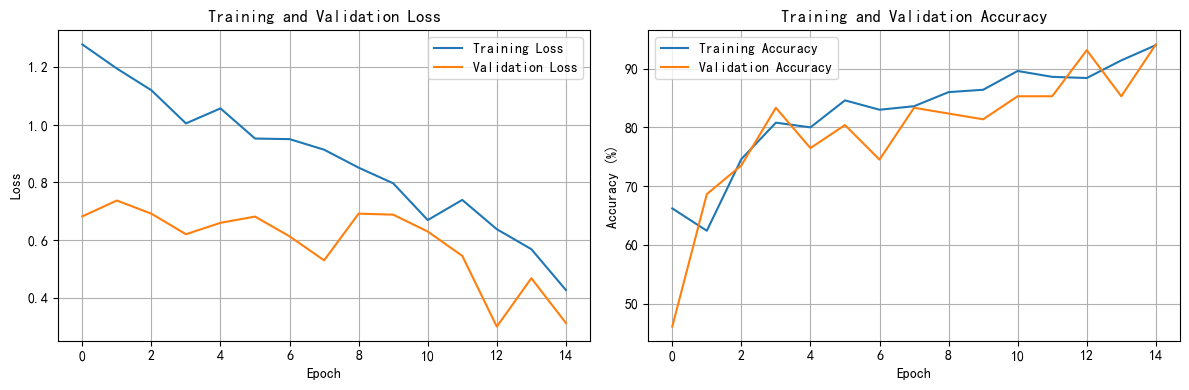

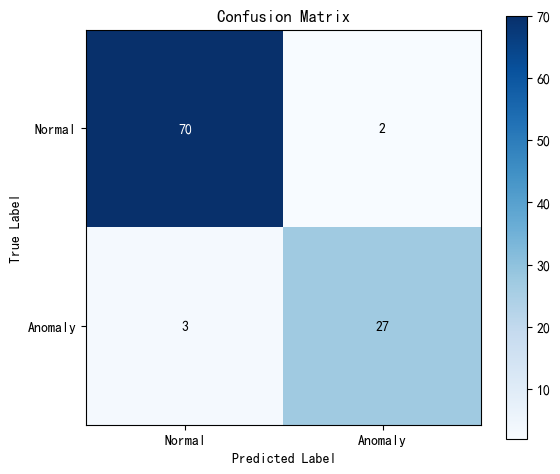

In [6]:
# Cell 6: 主训练函数和模型训练 (最终修复版)
"""
主训练流程。
这个单元格执行完整的模型训练，包含了所有必要的函数定义。
"""

def evaluate_model(model, test_loader, device, threshold=0.5):
    """全面评估模型"""
    model.eval()
    
    all_preds = []
    all_labels = []
    all_scores = []
    all_paths = []
    
    with torch.no_grad():
        for images, labels, paths in tqdm(test_loader, desc="评估"):
            images = images.float().to(device)
            
            outputs = model(images)
            
            if isinstance(model, AutoencoderAnomalyDetector):
                _, classification, _ = outputs
                scores = torch.softmax(classification, dim=1)[:, 1].cpu().numpy()
            elif isinstance(model, HybridAnomalyDetector):
                classification, anomaly_score, _ = outputs
                # 确保anomaly_score是一维的
                if anomaly_score.dim() > 1:
                    anomaly_score = anomaly_score.squeeze(-1)  # 修复：移除最后一维
                scores = anomaly_score.cpu().numpy()
            else:
                classification, anomaly_score = outputs
                # 确保anomaly_score是一维的
                if anomaly_score.dim() > 1:
                    anomaly_score = anomaly_score.squeeze(-1)  # 修复：移除最后一维
                scores = anomaly_score.cpu().numpy()
            
            # 使用阈值进行预测，而不是使用分类结果
            predictions = (scores > threshold).astype(int)
            
            all_preds.extend(predictions)
            all_labels.extend(labels.numpy())
            all_scores.extend(scores)
            all_paths.extend(paths)
    
    # 转换为numpy数组
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)
    
    # 计算指标
    accuracy = accuracy_score(all_labels, all_preds)
    
    # 处理类别不平衡
    if np.sum(all_preds) > 0:
        precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    else:
        precision = 0.0
        
    if np.sum(all_labels) > 0:
        recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    else:
        recall = 0.0
        
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    
    # 计算AUC（如果可能）
    try:
        auc = roc_auc_score(all_labels, all_scores)
    except:
        auc = 0.0
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'scores': all_scores,
        'paths': all_paths
    }


def find_optimal_threshold(model, test_loader, device):
    """寻找最优阈值"""
    model.eval()
    
    all_scores = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.float().to(device)
            
            outputs = model(images)
            
            if isinstance(model, AutoencoderAnomalyDetector):
                _, classification, _ = outputs
                scores = torch.softmax(classification, dim=1)[:, 1].cpu().numpy()
            elif isinstance(model, HybridAnomalyDetector):
                classification, anomaly_score, _ = outputs
                # 确保anomaly_score是一维的
                if anomaly_score.dim() > 1:
                    anomaly_score = anomaly_score.squeeze(-1)  # 修复：移除最后一维
                scores = anomaly_score.cpu().numpy()
            else:
                classification, anomaly_score = outputs
                # 确保anomaly_score是一维的
                if anomaly_score.dim() > 1:
                    anomaly_score = anomaly_score.squeeze(-1)  # 修复：移除最后一维
                scores = anomaly_score.cpu().numpy()
            
            all_scores.extend(scores)
            all_labels.extend(labels.numpy())
    
    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)
    
    # 使用ROC曲线寻找最优阈值
    from sklearn.metrics import roc_curve
    
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    
    # 寻找最大化F1分数的阈值
    best_threshold = 0.5
    best_f1 = 0
    
    for i in range(len(thresholds)):
        predictions = (all_scores > thresholds[i]).astype(int)
        
        if np.sum(predictions) > 0:
            precision = precision_score(all_labels, predictions, average='binary', zero_division=0)
        else:
            precision = 0.0
            
        if np.sum(all_labels) > 0:
            recall = recall_score(all_labels, predictions, average='binary', zero_division=0)
        else:
            recall = 0.0
            
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresholds[i]
    
    print(f"最优阈值: {best_threshold:.4f}, 对应F1分数: {best_f1:.4f}")
    
    return best_threshold


def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """绘制训练历史"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # 绘制损失曲线
    axes[0].plot(train_losses, label='Training Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # 绘制准确率曲线
    axes[1].plot(train_accs, label='Training Accuracy')
    axes[1].plot(val_accs, label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, classes=['Normal', 'Anomaly'], title='Confusion Matrix'):
    """绘制混淆矩阵"""
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # 设置坐标轴
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')
    
    # 在热力图中添加文本
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()


def train_epoch(model, dataloader, criterion_cls, criterion_anomaly, 
                optimizer, device, alpha=0.5):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    correct_cls = 0
    total = 0
    
    # 检查dataloader是否为空
    if dataloader is None:
        print("错误: dataloader为空!")
        return 0.0, 0.0
    
    progress_bar = tqdm(dataloader, desc="训练", leave=False)
    for batch_idx, (images, labels, _) in enumerate(progress_bar):
        try:
            images = images.float().to(device)
            labels = labels.long().to(device)
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(images)
            
            # 计算损失
            if isinstance(model, AutoencoderAnomalyDetector):
                reconstructed, classification, _ = outputs
                # 重构损失 + 分类损失
                loss_recon = F.mse_loss(reconstructed.float(), images.float())
                loss_cls = criterion_cls(classification, labels)
                loss = loss_recon + alpha * loss_cls
            elif isinstance(model, HybridAnomalyDetector):
                classification, anomaly_score, recon_error = outputs
                # 分类损失 + 重构损失 + 异常检测损失
                loss_cls = criterion_cls(classification, labels)
                loss_recon = recon_error.mean()
                
                # 对于异常检测，使用二元交叉熵
                # 确保anomaly_score形状正确
                if anomaly_score.dtype != torch.float32:
                    anomaly_score = anomaly_score.float()
                
                # 修复：确保anomaly_score是二维的 [batch_size, 1]
                if anomaly_score.dim() == 1:
                    anomaly_score_reshaped = anomaly_score.unsqueeze(1)
                elif anomaly_score.dim() == 3:
                    # 如果是三维的，压缩最后一维
                    anomaly_score_reshaped = anomaly_score.squeeze(-1)
                else:
                    anomaly_score_reshaped = anomaly_score
                    
                anomaly_labels = labels.float().unsqueeze(1)
                loss_anomaly = F.binary_cross_entropy(anomaly_score_reshaped, anomaly_labels)
                
                loss = loss_cls + 0.3 * loss_recon + 0.7 * loss_anomaly
            else:
                # 标准分类模型
                classification, anomaly_score = outputs
                
                # 确保classification是float32
                if classification.dtype != torch.float32:
                    classification = classification.float()
                
                # 分类损失
                loss_cls = criterion_cls(classification, labels)
                
                # 对于异常检测，使用二元交叉熵
                # 确保anomaly_score是float32
                if anomaly_score.dtype != torch.float32:
                    anomaly_score = anomaly_score.float()
                
                # 修复：确保anomaly_score是二维的 [batch_size, 1]
                if anomaly_score.dim() == 1:
                    anomaly_score_reshaped = anomaly_score.unsqueeze(1)
                elif anomaly_score.dim() == 3:
                    # 如果是三维的，压缩最后一维
                    anomaly_score_reshaped = anomaly_score.squeeze(-1)
                else:
                    anomaly_score_reshaped = anomaly_score
                    
                anomaly_labels = labels.float().unsqueeze(1)
                loss_anomaly = F.binary_cross_entropy(anomaly_score_reshaped, anomaly_labels)
                
                loss = loss_cls + loss_anomaly
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            # 统计
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(classification.data, 1)
            total += labels.size(0)
            correct_cls += (predicted == labels).sum().item()
            
            # 更新进度条
            progress_bar.set_postfix({
                'loss': running_loss / total,
                'acc': 100. * correct_cls / total
            })
        except Exception as e:
            print(f"批次 {batch_idx} 训练时出错: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    if total == 0:
        return 0.0, 0.0
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct_cls / total
    
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion_cls, device):
    """验证模型"""
    model.eval()
    running_loss = 0.0
    correct_cls = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_scores = []
    
    # 检查dataloader是否为空
    if dataloader is None:
        print("错误: dataloader为空!")
        return 0.0, 0.0, np.array([]), np.array([]), np.array([])
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="验证", leave=False)
        for images, labels, _ in progress_bar:
            try:
                images = images.float().to(device)
                labels = labels.long().to(device)
                
                # 前向传播
                outputs = model(images)
                
                # 获取分类输出
                if isinstance(model, AutoencoderAnomalyDetector):
                    _, classification, _ = outputs
                    scores = torch.softmax(classification, dim=1)[:, 1]
                elif isinstance(model, HybridAnomalyDetector):
                    classification, anomaly_score, _ = outputs
                    # 确保anomaly_score是float32
                    if anomaly_score.dtype != torch.float32:
                        anomaly_score = anomaly_score.float()
                    # 确保anomaly_score是一维的
                    if anomaly_score.dim() > 1:
                        anomaly_score = anomaly_score.squeeze(-1)  # 修复：移除最后一维
                    scores = anomaly_score
                else:
                    classification, anomaly_score = outputs
                    # 确保anomaly_score是float32
                    if anomaly_score.dtype != torch.float32:
                        anomaly_score = anomaly_score.float()
                    # 确保anomaly_score是一维的
                    if anomaly_score.dim() > 1:
                        anomaly_score = anomaly_score.squeeze(-1)  # 修复：移除最后一维
                    scores = anomaly_score
                
                # 确保classification是float32
                if classification.dtype != torch.float32:
                    classification = classification.float()
                
                # 计算损失
                loss = criterion_cls(classification, labels)
                
                # 统计
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(classification.data, 1)
                total += labels.size(0)
                correct_cls += (predicted == labels).sum().item()
                
                # 收集预测和标签
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_scores.extend(scores.cpu().numpy())
                
                # 更新进度条
                progress_bar.set_postfix({
                    'loss': running_loss / total,
                    'acc': 100. * correct_cls / total
                })
            except Exception as e:
                print(f"验证批次处理时出错: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    if total == 0:
        return 0.0, 0.0, np.array([]), np.array([]), np.array([])
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct_cls / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_scores)


def train_model(model_name='resnet', categories=None, epochs=20, batch_size=16, 
                learning_rate=0.001, root_dir='.'):
    """训练异常检测模型"""
    
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # 如果未指定类别，使用所有类别
    if categories is None:
        categories = ['hazelnut', 'zipper']
    
    # 检查根目录是否存在
    print(f"根目录: {root_dir}")
    print(f"当前工作目录: {os.getcwd()}")
    
    if not os.path.exists(root_dir):
        print(f"错误: 根目录不存在: {root_dir}")
        return None, None, None, None, None
    
    print(f"类别: {categories}")
    
    # 列出根目录内容
    print(f"\n根目录内容:")
    for item in sorted(os.listdir(root_dir)):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path):
            print(f"  目录: {item}")
        elif item.endswith(('.json', '.ipynb')):
            print(f"  文件: {item}")
    
    # 创建数据加载器
    json_path = os.path.join(root_dir, 'image_anomaly_labels.json')
    print(f"\nJSON文件路径: {json_path}")
    print(f"JSON文件存在: {os.path.exists(json_path)}")
    
    # 如果JSON文件不存在，尝试在当前目录查找
    if not os.path.exists(json_path):
        # 尝试直接在当前目录查找
        if os.path.exists('image_anomaly_labels.json'):
            json_path = 'image_anomaly_labels.json'
            print(f"使用JSON文件: {json_path}")
        else:
            print("警告: 找不到JSON文件")
    
    train_loader, test_loader, train_dataset, test_dataset = create_data_loaders(
        root_dir=root_dir,
        categories=categories,
        batch_size=batch_size,
        use_json=True,
        json_path=json_path,
        num_workers=0  # Windows上必须设置为0
    )
    
    # 检查数据加载器是否成功创建
    if train_loader is None or test_loader is None:
        print("\n无法继续训练，因为数据加载器创建失败!")
        
        # 尝试直接检查数据是否存在
        print("\n手动检查数据目录结构:")
        for category in categories:
            print(f"\n检查类别: {category}")
            category_path = os.path.join(root_dir, category)
            if os.path.exists(category_path):
                print(f"  {category_path} 存在")
                # 检查train文件夹
                train_path = os.path.join(category_path, 'train')
                if os.path.exists(train_path):
                    print(f"    train文件夹存在，包含: {os.listdir(train_path)}")
                    # 检查good和bad文件夹
                    good_path = os.path.join(train_path, 'good')
                    bad_path = os.path.join(train_path, 'bad')
                    print(f"    good文件夹存在: {os.path.exists(good_path)}")
                    if os.path.exists(good_path):
                        good_files = [f for f in os.listdir(good_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                        print(f"      good文件夹中有 {len(good_files)} 个图像文件")
                        if len(good_files) > 0:
                            print(f"      示例: {good_files[:3]}")
                    print(f"    bad文件夹存在: {os.path.exists(bad_path)}")
                    if os.path.exists(bad_path):
                        bad_files = [f for f in os.listdir(bad_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                        print(f"      bad文件夹中有 {len(bad_files)} 个图像文件")
                        if len(bad_files) > 0:
                            print(f"      示例: {bad_files[:3]}")
                else:
                    print(f"    train文件夹不存在!")
                
                # 检查test文件夹
                test_path = os.path.join(category_path, 'test')
                if os.path.exists(test_path):
                    print(f"    test文件夹存在，包含: {os.listdir(test_path)}")
                    # 检查good和bad文件夹
                    good_path = os.path.join(test_path, 'good')
                    bad_path = os.path.join(test_path, 'bad')
                    print(f"    good文件夹存在: {os.path.exists(good_path)}")
                    if os.path.exists(good_path):
                        good_files = [f for f in os.listdir(good_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                        print(f"      good文件夹中有 {len(good_files)} 个图像文件")
                        if len(good_files) > 0:
                            print(f"      示例: {good_files[:3]}")
                    print(f"    bad文件夹存在: {os.path.exists(bad_path)}")
                    if os.path.exists(bad_path):
                        bad_files = [f for f in os.listdir(bad_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                        print(f"      bad文件夹中有 {len(bad_files)} 个图像文件")
                        if len(bad_files) > 0:
                            print(f"      示例: {bad_files[:3]}")
                else:
                    print(f"    test文件夹不存在!")
            else:
                print(f"  {category_path} 不存在!")
        
        return None, None, None, None, None
    
    # 获取模型
    model = get_model(model_name, device)
    
    # 重要修复：确保模型参数是float32
    model = model.float()
    print("模型已转换为float32")
    
    # 定义损失函数和优化器
    # 使用加权损失函数来处理类别不平衡
    class_counts = train_dataset.get_class_distribution()
    if 0 in class_counts and 1 in class_counts:
        total = class_counts[0] + class_counts[1]
        weight_for_0 = total / (2.0 * class_counts[0])
        weight_for_1 = total / (2.0 * class_counts[1])
        class_weights = torch.tensor([weight_for_0, weight_for_1]).float().to(device)  # 确保权重是float32
        print(f"类别权重: 正常={weight_for_0:.2f}, 异常={weight_for_1:.2f}")
    else:
        class_weights = None
    
    criterion_cls = nn.CrossEntropyLoss(weight=class_weights)
    
    if isinstance(model, HybridAnomalyDetector):
        # 对于混合模型，使用Adam优化器
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    # 训练历史
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # 最佳模型参数
    best_val_acc = 0.0
    best_model_state = None
    
    print(f"\n开始训练 {model_name} 模型...")
    print(f"训练样本: {len(train_dataset)}, 测试样本: {len(test_dataset)}")
    print(f"训练集分布: {class_counts}")
    
    # 检查类别分布
    train_category_dist = train_dataset.get_category_distribution()
    test_category_dist = test_dataset.get_category_distribution()
    print(f"训练集类别分布: {train_category_dist}")
    print(f"测试集类别分布: {test_category_dist}")
    
    # 检查第一个批次的数据
    print("\n检查第一个批次的数据...")
    try:
        for images, labels, paths in train_loader:
            print(f"批次图像形状: {images.shape}")
            print(f"批次标签形状: {labels.shape}")
            print(f"图像数据类型: {images.dtype}")
            print(f"标签数据类型: {labels.dtype}")
            print(f"标签分布: {torch.bincount(labels)}")
            break
    except Exception as e:
        print(f"检查数据批次时出错: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        # 训练
        try:
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion_cls, None, optimizer, device
            )
        except Exception as e:
            print(f"训练过程中出错: {e}")
            import traceback
            traceback.print_exc()
            break
        
        # 验证
        try:
            val_loss, val_acc, _, _, _ = validate(
                model, test_loader, criterion_cls, device
            )
        except Exception as e:
            print(f"验证过程中出错: {e}")
            import traceback
            traceback.print_exc()
            break
        
        # 更新学习率
        scheduler.step(val_loss)
        
        # 保存训练历史
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # 打印结果
        print(f"训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.2f}%")
        print(f"验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.2f}%")
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"新的最佳模型! 验证准确率: {val_acc:.2f}%")
    
    # 如果训练被中断，检查是否有历史记录
    if len(train_losses) == 0:
        print("\n训练过程中断，没有训练历史记录")
        return model, None, train_dataset, test_dataset, None
    
    # 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n加载最佳模型，验证准确率: {best_val_acc:.2f}%")
    
    # 寻找最优阈值
    print("\n寻找最优阈值...")
    optimal_threshold = find_optimal_threshold(model, test_loader, device)
    
    # 使用最优阈值评估模型
    print(f"\n使用最优阈值 {optimal_threshold:.4f} 评估模型性能...")
    try:
        eval_results = evaluate_model(model, test_loader, device, threshold=optimal_threshold)
    except Exception as e:
        print(f"评估模型时出错: {e}")
        import traceback
        traceback.print_exc()
        # 创建空的评估结果
        eval_results = {
            'accuracy': 0,
            'precision': 0,
            'recall': 0,
            'f1_score': 0,
            'auc': 0,
            'confusion_matrix': np.zeros((2, 2), dtype=int)
        }
    
    # 打印评估结果
    print(f"\n测试集性能 (阈值={optimal_threshold:.4f}):")
    print(f"准确率: {eval_results['accuracy']:.4f}")
    print(f"精确率: {eval_results['precision']:.4f}")
    print(f"召回率: {eval_results['recall']:.4f}")
    print(f"F1分数: {eval_results['f1_score']:.4f}")
    print(f"AUC: {eval_results['auc']:.4f}")
    
    # 打印详细统计
    print(f"正常样本数: {np.sum(eval_results['labels'] == 0)}")
    print(f"异常样本数: {np.sum(eval_results['labels'] == 1)}")
    print(f"预测为异常数: {np.sum(eval_results['predictions'] == 1)}")
    print(f"预测为正常数: {np.sum(eval_results['predictions'] == 0)}")
    
    # 绘制训练历史
    if len(train_losses) > 0:
        plot_training_history(train_losses, val_losses, train_accs, val_accs)
    
    # 绘制混淆矩阵
    plot_confusion_matrix(eval_results['confusion_matrix'])
    
    return model, eval_results, train_dataset, test_dataset, optimal_threshold


# 训练模型
print("开始训练模型...")
model, results, train_dataset, test_dataset, optimal_threshold = train_model(
    model_name='resnet',
    categories=['hazelnut', 'zipper'],
    epochs=15,
    batch_size=8,  # 减少批次大小以避免内存问题
    learning_rate=0.001,
    root_dir='.'  # 关键修改：使用当前目录
)

d:\ANACONDA\CONDA\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


开始训练集成模型...
训练集成模型...
创建训练数据集...
从文件夹加载train数据...
类别 hazelnut train 正常样本: 200 张
类别 hazelnut train 异常样本: 50 张
类别 zipper train 正常样本: 200 张
类别 zipper train 异常样本: 50 张
从文件夹加载了 500 个样本，类别: ['hazelnut', 'zipper'], 划分: train
创建测试数据集...
从JSON文件加载test数据...
从JSON加载了 102 个测试样本

数据集统计:
训练集: 500 个样本, 分布: {0: 400, 1: 100}
测试集: 102 个样本, 分布: {0: 72, 1: 30}

训练 resnet 模型 #1...
类别权重: 正常=0.62, 异常=2.50

Epoch 1/12
--------------------------------------------------


训练损失: 0.6164, 训练准确率: 70.40%
验证损失: 0.4415, 验证准确率: 80.39%
新的最佳模型! 验证准确率: 80.39%

Epoch 2/12
--------------------------------------------------


训练损失: 0.5024, 训练准确率: 83.80%
验证损失: 0.3434, 验证准确率: 69.61%

Epoch 3/12
--------------------------------------------------


训练损失: 0.4581, 训练准确率: 83.00%
验证损失: 0.3699, 验证准确率: 87.25%
新的最佳模型! 验证准确率: 87.25%

Epoch 4/12
--------------------------------------------------


训练损失: 0.3758, 训练准确率: 88.40%
验证损失: 0.2620, 验证准确率: 93.14%
新的最佳模型! 验证准确率: 93.14%

Epoch 5/12
--------------------------------------------------


训练损失: 0.4572, 训练准确率: 82.60%
验证损失: 0.2407, 验证准确率: 96.08%
新的最佳模型! 验证准确率: 96.08%

Epoch 6/12
--------------------------------------------------


训练损失: 0.4261, 训练准确率: 87.20%
验证损失: 0.2324, 验证准确率: 95.10%

Epoch 7/12
--------------------------------------------------


训练损失: 0.2490, 训练准确率: 94.00%
验证损失: 0.2018, 验证准确率: 96.08%

Epoch 8/12
--------------------------------------------------


训练损失: 0.2833, 训练准确率: 91.20%
验证损失: 0.1593, 验证准确率: 94.12%

Epoch 9/12
--------------------------------------------------


训练损失: 0.2674, 训练准确率: 92.80%
验证损失: 0.0794, 验证准确率: 99.02%
新的最佳模型! 验证准确率: 99.02%

Epoch 10/12
--------------------------------------------------


训练损失: 0.2425, 训练准确率: 94.00%
验证损失: 0.2141, 验证准确率: 97.06%

Epoch 11/12
--------------------------------------------------


训练损失: 0.2491, 训练准确率: 93.00%
验证损失: 0.0587, 验证准确率: 100.00%
新的最佳模型! 验证准确率: 100.00%

Epoch 12/12
--------------------------------------------------


训练损失: 0.1620, 训练准确率: 95.40%
验证损失: 0.0905, 验证准确率: 98.04%
加载最佳模型，验证准确率: 100.00%
resnet 模型 #1 训练完成

训练 resnet 模型 #2...
类别权重: 正常=0.62, 异常=2.50

Epoch 1/12
--------------------------------------------------


训练损失: 0.6053, 训练准确率: 70.00%
验证损失: 0.5529, 验证准确率: 72.55%
新的最佳模型! 验证准确率: 72.55%

Epoch 2/12
--------------------------------------------------


训练损失: 0.5913, 训练准确率: 76.20%
验证损失: 0.5389, 验证准确率: 79.41%
新的最佳模型! 验证准确率: 79.41%

Epoch 3/12
--------------------------------------------------


训练损失: 0.5527, 训练准确率: 79.60%
验证损失: 1.1114, 验证准确率: 77.45%

Epoch 4/12
--------------------------------------------------


训练损失: 0.5093, 训练准确率: 83.60%
验证损失: 0.4181, 验证准确率: 86.27%
新的最佳模型! 验证准确率: 86.27%

Epoch 5/12
--------------------------------------------------


训练损失: 0.5197, 训练准确率: 84.60%
验证损失: 0.4617, 验证准确率: 80.39%

Epoch 6/12
--------------------------------------------------


训练损失: 0.4401, 训练准确率: 87.00%
验证损失: 0.3376, 验证准确率: 92.16%
新的最佳模型! 验证准确率: 92.16%

Epoch 7/12
--------------------------------------------------


训练损失: 0.4032, 训练准确率: 88.80%
验证损失: 0.3580, 验证准确率: 92.16%

Epoch 8/12
--------------------------------------------------


训练损失: 0.3671, 训练准确率: 90.60%
验证损失: 0.3337, 验证准确率: 91.18%

Epoch 9/12
--------------------------------------------------


训练损失: 0.3469, 训练准确率: 89.80%
验证损失: 0.3787, 验证准确率: 90.20%

Epoch 10/12
--------------------------------------------------


训练损失: 0.3617, 训练准确率: 90.40%
验证损失: 0.4141, 验证准确率: 88.24%

Epoch 11/12
--------------------------------------------------


训练损失: 0.3071, 训练准确率: 92.60%
验证损失: 0.2118, 验证准确率: 95.10%
新的最佳模型! 验证准确率: 95.10%

Epoch 12/12
--------------------------------------------------


训练损失: 0.3791, 训练准确率: 91.20%
验证损失: 0.4195, 验证准确率: 89.22%
加载最佳模型，验证准确率: 95.10%
resnet 模型 #2 训练完成

将主模型加入集成...
主模型已加入集成
集成模型数量: 3
模型权重: [0.3, 0.3, 0.4]

寻找最优阈值...


最优阈值: 0.3281, 对应F1分数: 0.9333


集成模型性能:
准确率: 0.9608
精确率: 0.9333
召回率: 0.9333
F1分数: 0.9333
AUC: 0.9750

混淆矩阵分析:
真阴性(TN): 70 - 正确识别的正常样本
假阳性(FP): 2 - 正常样本被误判为异常
假阴性(FN): 2 - 异常样本被误判为正常
真阳性(TP): 28 - 正确识别的异常样本


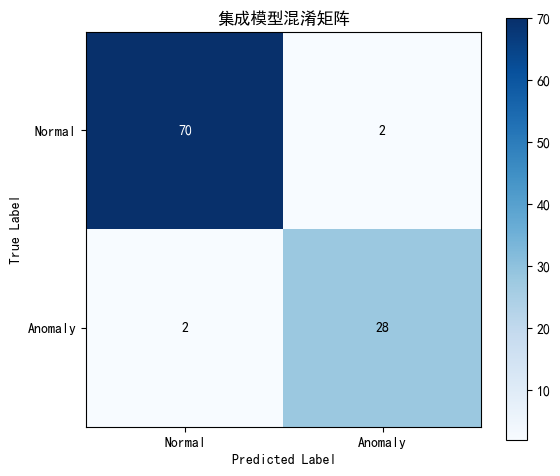

In [7]:
# Cell 7: 集成学习和多模型融合 (最终修正版)
"""
集成多个模型以提高性能。
这个单元格实现了模型集成策略。
"""

class ModelEnsemble:
    """模型集成类"""
    
    def __init__(self, models, weights=None):
        """
        初始化集成模型
        
        参数:
            models: 模型列表
            weights: 各模型的权重
        """
        self.models = models
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 设置权重
        if weights is None:
            self.weights = [1.0 / len(models)] * len(models)
        else:
            total = sum(weights)
            self.weights = [w / total for w in weights]
    
    def predict(self, dataloader):
        """集成预测"""
        all_predictions = []
        all_scores = []
        
        for model, weight in zip(self.models, self.weights):
            model.eval()
            model_predictions = []
            model_scores = []
            
            with torch.no_grad():
                for images, _, _ in tqdm(dataloader, desc=f"模型预测", leave=False):
                    images = images.float().to(self.device)
                    
                    outputs = model(images)
                    
                    if isinstance(model, AutoencoderAnomalyDetector):
                        _, classification, _ = outputs
                        scores = torch.softmax(classification, dim=1)[:, 1]
                    elif isinstance(model, HybridAnomalyDetector):
                        classification, anomaly_score, _ = outputs
                        # 确保anomaly_score是一维的
                        if anomaly_score.dim() > 1:
                            anomaly_score = anomaly_score.squeeze(-1)
                        scores = anomaly_score
                    else:
                        # 对于AnomalyDetector，返回的是(classification, anomaly_score)
                        classification, anomaly_score = outputs
                        # 确保anomaly_score是一维的
                        if anomaly_score.dim() > 1:
                            anomaly_score = anomaly_score.squeeze(-1)
                        scores = anomaly_score
                    
                    _, predicted = torch.max(classification, 1)
                    
                    model_predictions.append(predicted.cpu())
                    model_scores.append(scores.cpu())
            
            model_predictions = torch.cat(model_predictions).numpy()
            model_scores = torch.cat(model_scores).numpy()
            
            all_predictions.append(model_predictions)
            all_scores.append(model_scores * weight)
        
        # 加权投票
        weighted_predictions = np.zeros_like(all_predictions[0], dtype=float)
        for pred, weight in zip(all_predictions, self.weights):
            weighted_predictions += pred * weight
        
        # 加权分数
        weighted_scores = np.sum(all_scores, axis=0)
        
        # 最终预测（四舍五入）
        final_predictions = (weighted_predictions > 0.5).astype(int)
        
        return final_predictions, weighted_scores
    
    def evaluate(self, test_loader, threshold=0.5):
        """评估集成模型"""
        predictions, scores = self.predict(test_loader)
        
        # 获取真实标签
        all_labels = []
        for _, labels, _ in test_loader:
            all_labels.append(labels.numpy())
        all_labels = np.concatenate(all_labels)
        
        # 使用阈值进行预测
        threshold_predictions = (scores > threshold).astype(int)
        
        # 计算指标
        accuracy = accuracy_score(all_labels, threshold_predictions)
        
        if np.sum(threshold_predictions) > 0:
            precision = precision_score(all_labels, threshold_predictions, average='binary', zero_division=0)
        else:
            precision = 0.0
            
        if np.sum(all_labels) > 0:
            recall = recall_score(all_labels, threshold_predictions, average='binary', zero_division=0)
        else:
            recall = 0.0
            
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0
        
        try:
            auc = roc_auc_score(all_labels, scores)
        except:
            auc = 0.0
        
        cm = confusion_matrix(all_labels, threshold_predictions)
        
        print(f"集成模型性能:")
        print(f"准确率: {accuracy:.4f}")
        print(f"精确率: {precision:.4f}")
        print(f"召回率: {recall:.4f}")
        print(f"F1分数: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        
        print(f"\n混淆矩阵分析:")
        print(f"真阴性(TN): {cm[0,0]} - 正确识别的正常样本")
        print(f"假阳性(FP): {cm[0,1]} - 正常样本被误判为异常")
        print(f"假阴性(FN): {cm[1,0]} - 异常样本被误判为正常")
        print(f"真阳性(TP): {cm[1,1]} - 正确识别的异常样本")
        
        plot_confusion_matrix(cm, title='集成模型混淆矩阵')
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'confusion_matrix': cm
        }


def train_ensemble_models(root_dir='.'):
    """训练多个模型并集成"""
    print("训练集成模型...")
    
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 创建数据加载器
    json_path = os.path.join(root_dir, 'image_anomaly_labels.json')
    train_loader, test_loader, train_dataset, test_dataset = create_data_loaders(
        root_dir=root_dir,
        categories=['hazelnut', 'zipper'],
        batch_size=8,
        use_json=True,
        json_path=json_path,
        num_workers=0
    )
    
    # 检查数据加载器
    if train_loader is None or test_loader is None:
        print("无法创建数据加载器，集成模型训练中止!")
        return None, None
    
    models = []
    model_names = ['resnet', 'resnet']  # 训练两个不同初始化的模型
    
    for model_idx, model_name in enumerate(model_names):
        print(f"\n训练 {model_name} 模型 #{model_idx+1}...")
        
        # 创建模型
        model = get_model(model_name, device)
        model = model.float()
        
        # 定义损失函数和优化器
        class_counts = train_dataset.get_class_distribution()
        if 0 in class_counts and 1 in class_counts:
            total = class_counts[0] + class_counts[1]
            weight_for_0 = total / (2.0 * class_counts[0])
            weight_for_1 = total / (2.0 * class_counts[1])
            class_weights = torch.tensor([weight_for_0, weight_for_1]).float().to(device)
            print(f"类别权重: 正常={weight_for_0:.2f}, 异常={weight_for_1:.2f}")
        else:
            class_weights = None
        
        # 关键修复：对于集成训练，只使用分类损失
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        # 使用不同的学习率来增加模型多样性
        if model_idx == 0:
            optimizer = optim.Adam(model.parameters(), lr=0.0003)
        else:
            optimizer = optim.Adam(model.parameters(), lr=0.0005)
        
        # 学习率调度器
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )
        
        # 训练模型
        num_epochs = 12
        
        best_val_acc = 0.0
        best_model_state = None
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            # 训练阶段
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for images, labels, _ in tqdm(train_loader, desc="训练", leave=False):
                try:
                    images = images.float().to(device)
                    labels = labels.long().to(device)
                    
                    optimizer.zero_grad()
                    
                    # 前向传播
                    outputs = model(images)
                    
                    # 正确处理模型输出
                    if isinstance(model, AutoencoderAnomalyDetector):
                        _, classification, _ = outputs
                    elif isinstance(model, HybridAnomalyDetector):
                        classification, _, _ = outputs
                    else:
                        # 对于AnomalyDetector，我们只需要分类输出
                        classification, _ = outputs
                    
                    # 计算损失
                    loss = criterion(classification, labels)
                    
                    # 反向传播
                    loss.backward()
                    optimizer.step()
                    
                    # 统计
                    train_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(classification.data, 1)
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()
                    
                except Exception as e:
                    print(f"训练批次出错: {e}")
                    continue
            
            train_loss = train_loss / train_total if train_total > 0 else 0.0
            train_acc = 100. * train_correct / train_total if train_total > 0 else 0.0
            
            # 验证阶段
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for images, labels, _ in tqdm(test_loader, desc="验证", leave=False):
                    try:
                        images = images.float().to(device)
                        labels = labels.long().to(device)
                        
                        # 前向传播
                        outputs = model(images)
                        
                        # 正确处理模型输出
                        if isinstance(model, AutoencoderAnomalyDetector):
                            _, classification, _ = outputs
                        elif isinstance(model, HybridAnomalyDetector):
                            classification, _, _ = outputs
                        else:
                            classification, _ = outputs
                        
                        # 计算损失
                        loss = criterion(classification, labels)
                        
                        # 统计
                        val_loss += loss.item() * images.size(0)
                        _, predicted = torch.max(classification.data, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()
                        
                    except Exception as e:
                        print(f"验证批次出错: {e}")
                        continue
            
            val_loss = val_loss / val_total if val_total > 0 else 0.0
            val_acc = 100. * val_correct / val_total if val_total > 0 else 0.0
            
            # 更新学习率
            scheduler.step(val_loss)
            
            print(f"训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.2f}%")
            print(f"验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.2f}%")
            
            # 保存最佳模型
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()
                print(f"新的最佳模型! 验证准确率: {val_acc:.2f}%")
        
        # 加载最佳模型
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f"加载最佳模型，验证准确率: {best_val_acc:.2f}%")
        
        models.append(model)
        print(f"{model_name} 模型 #{model_idx+1} 训练完成")
    
    # 将之前训练好的主模型加入集成
    print("\n将主模型加入集成...")
    if 'model' in globals():
        # 获取全局的主模型
        main_model = globals()['model']
        # 确保主模型在相同设备上
        main_model = main_model.to(device)
        models.append(main_model)
        print("主模型已加入集成")
    else:
        print("警告: 未找到主模型")
    
    # 创建集成模型
    if len(models) > 0:
        # 为每个模型分配权重
        # 给主模型更高的权重，因为它的性能更好
        if len(models) == 3:  # 2个新模型 + 1个主模型
            weights = [0.3, 0.3, 0.4]  # 主模型权重最高
        elif len(models) == 2:  # 2个新模型
            weights = [0.5, 0.5]
        else:  # 只有1个模型
            weights = [1.0]
        
        print(f"集成模型数量: {len(models)}")
        print(f"模型权重: {weights}")
        
        ensemble = ModelEnsemble(models, weights=weights)
    else:
        print("没有模型可以集成!")
        return None, None
    
    # 寻找最优阈值
    print("\n寻找最优阈值...")
    
    # 使用集成模型预测测试集，获取分数
    predictions, scores = ensemble.predict(test_loader)
    
    # 获取真实标签
    all_labels = []
    for _, labels, _ in test_loader:
        all_labels.append(labels.numpy())
    all_labels = np.concatenate(all_labels)
    
    # 使用ROC曲线寻找最优阈值
    from sklearn.metrics import roc_curve
    
    fpr, tpr, thresholds = roc_curve(all_labels, scores)
    
    best_threshold = 0.5
    best_f1 = 0
    
    for i in range(len(thresholds)):
        threshold_predictions = (scores > thresholds[i]).astype(int)
        
        if np.sum(threshold_predictions) > 0:
            precision = precision_score(all_labels, threshold_predictions, average='binary', zero_division=0)
        else:
            precision = 0.0
            
        if np.sum(all_labels) > 0:
            recall = recall_score(all_labels, threshold_predictions, average='binary', zero_division=0)
        else:
            recall = 0.0
            
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresholds[i]
    
    print(f"最优阈值: {best_threshold:.4f}, 对应F1分数: {best_f1:.4f}")
    
    # 使用最优阈值评估集成模型
    ensemble_results = ensemble.evaluate(test_loader, threshold=best_threshold)
    
    return ensemble, ensemble_results


# 训练集成模型
print("开始训练集成模型...")
ensemble, ensemble_results = train_ensemble_models()

执行可视化分析...
使用已存在的模型
警告: test_dataset或test_loader未定义，将重新创建...
JSON文件路径: image_anomaly_labels.json
JSON文件存在: True
创建训练数据集...
从文件夹加载train数据...
类别 hazelnut train 正常样本: 200 张
类别 hazelnut train 异常样本: 50 张
类别 zipper train 正常样本: 200 张
类别 zipper train 异常样本: 50 张
从文件夹加载了 500 个样本，类别: ['hazelnut', 'zipper'], 划分: train
创建测试数据集...
从JSON文件加载test数据...
从JSON加载了 102 个测试样本

数据集统计:
训练集: 500 个样本, 分布: {0: 400, 1: 100}
测试集: 102 个样本, 分布: {0: 72, 1: 30}
成功创建数据加载器

测试集统计:
总样本数: 102
类别分布: {0: 72, 1: 30}
类别信息分布: {'hazelnut': 55, 'zipper': 47}

1. 可视化模型预测（平衡采样）...
测试集类别分布:
  hazelnut: 55 个样本
  zipper: 47 个样本


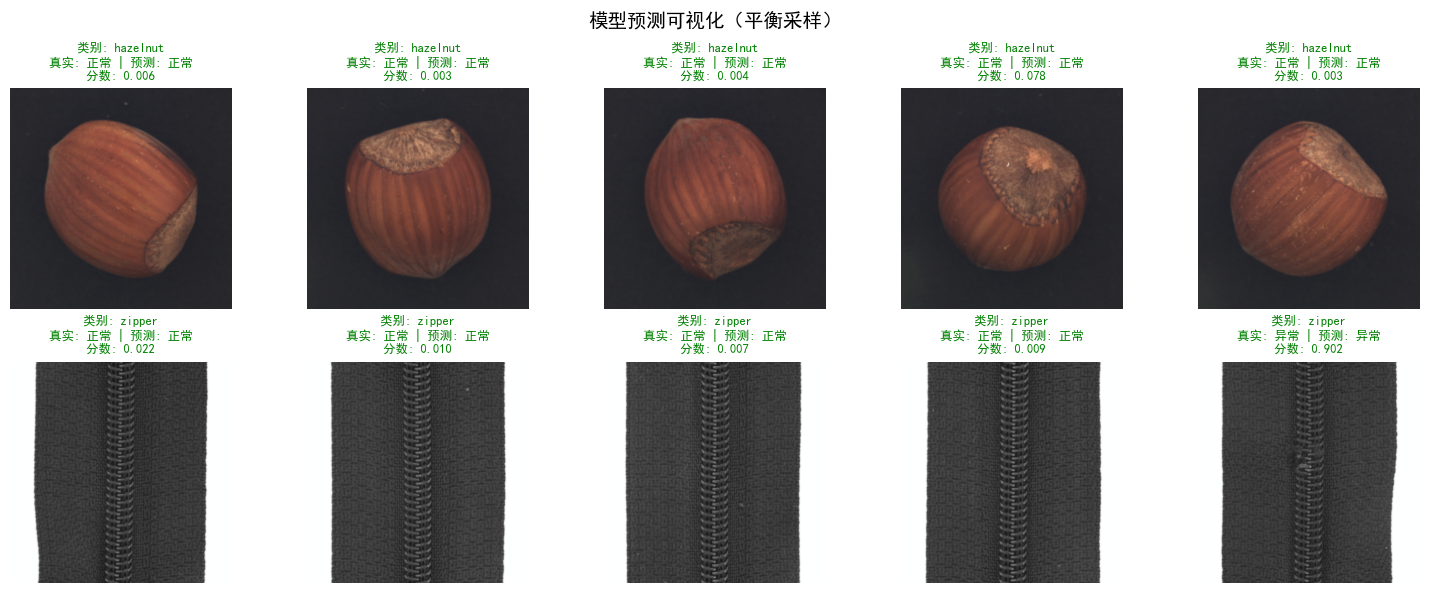


可视化样本统计:
总样本数: 10
  hazelnut: 5 个样本
  zipper: 5 个样本
  正常样本: 9 个
  异常样本: 1 个
  本批次准确率: 100.00%

2. 可视化特征空间...


提取特征: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


特征维度太高 (512)，先进行PCA降维到50维...
降维后特征维度: 50


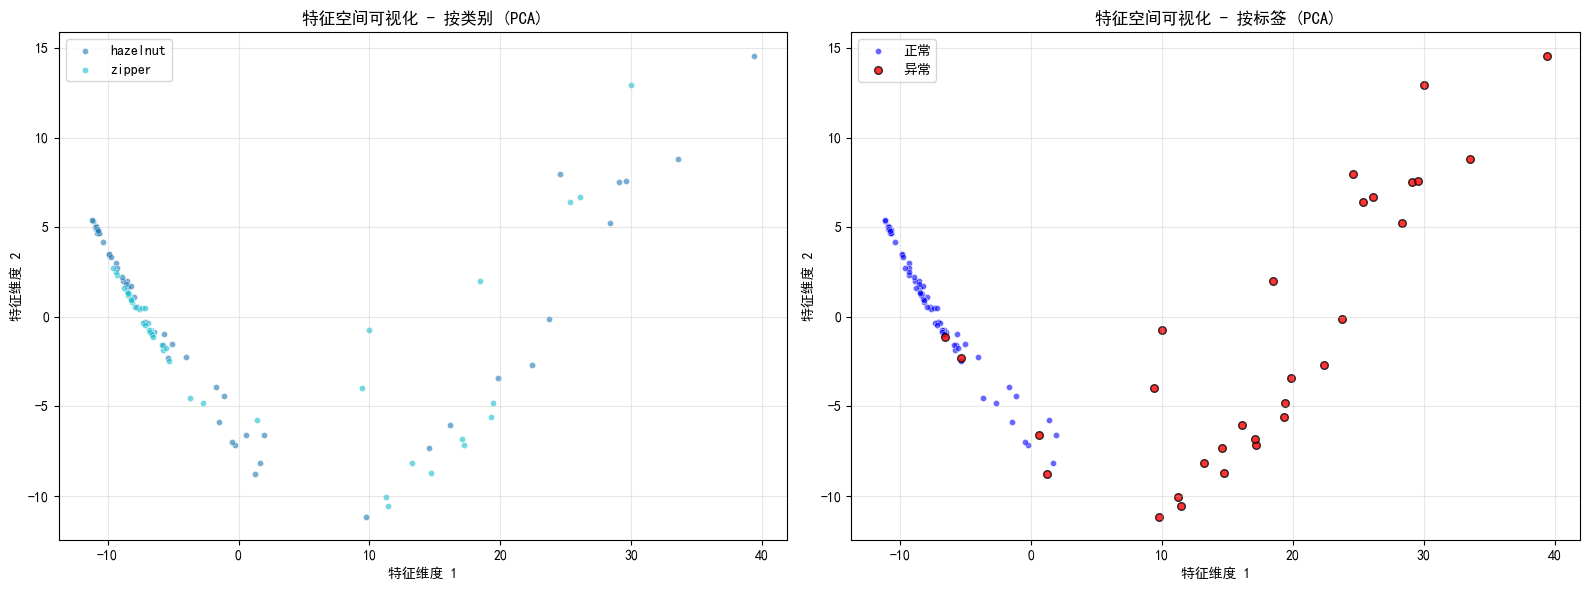


特征空间可视化统计:
总样本数: 102
特征维度: 50 -> 2
类别分布:
  hazelnut: 55 个样本
  zipper: 47 个样本

3. 分析失败案例...


收集预测结果: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]



发现 6 个错误分类的样本
错误分类样本的类别分布:
  hazelnut: 3 个
  zipper: 3 个


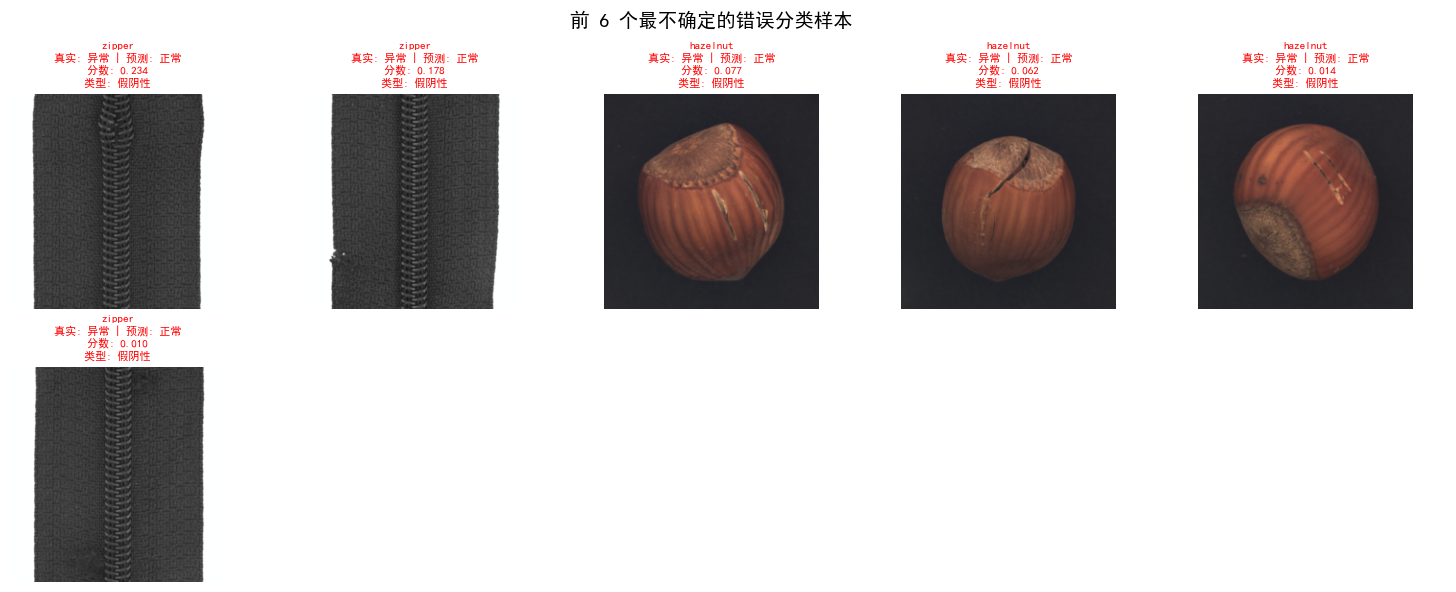


错误分析详细统计:
总错误数: 6
假阳性 (正常被误判为异常): 0 个
假阴性 (异常被误判为正常): 6 个

假阴性分析:
  hazelnut: 3 个
  zipper: 3 个

可视化分析完成!


In [8]:
# Cell 8: 异常检测和可视化 (完整修复版)
"""
可视化异常检测结果。
这个单元格包含可视化函数和异常样本分析。
"""

def visualize_predictions(model, test_dataset, test_loader, device, num_samples=10):
    """可视化模型预测结果，平衡地从所有类别采样"""
    model.eval()
    
    # 确保有足够的数据
    if len(test_dataset) == 0:
        print("错误: 测试数据集为空!")
        return
    
    # 收集所有样本的信息
    all_indices = list(range(len(test_dataset)))
    
    # 按类别分组样本索引
    category_indices = {}
    for idx in all_indices:
        _, _, path = test_dataset[idx]
        # 从路径中提取类别
        if 'hazelnut' in path:
            category = 'hazelnut'
        elif 'zipper' in path:
            category = 'zipper'
        else:
            category = 'unknown'
        
        if category not in category_indices:
            category_indices[category] = []
        category_indices[category].append(idx)
    
    # 打印类别分布信息
    print(f"测试集类别分布:")
    for category, indices in category_indices.items():
        print(f"  {category}: {len(indices)} 个样本")
    
    # 从每个类别平衡采样
    selected_indices = []
    categories = list(category_indices.keys())
    
    if len(categories) == 0:
        print("错误: 没有找到任何类别!")
        return
    
    # 计算每个类别应该采样的数量
    samples_per_category = max(1, num_samples // len(categories))
    
    for category in categories:
        indices = category_indices[category]
        if len(indices) > 0:
            # 随机采样，但确保有代表性
            if len(indices) <= samples_per_category:
                selected = indices
            else:
                # 从开头、中间、结尾各取一些样本
                step = max(1, len(indices) // samples_per_category)
                selected = indices[::step][:samples_per_category]
                # 如果还不够，随机补充
                if len(selected) < samples_per_category:
                    import random
                    remaining = [i for i in indices if i not in selected]
                    if remaining:
                        additional = random.sample(remaining, min(samples_per_category - len(selected), len(remaining)))
                        selected.extend(additional)
            
            selected_indices.extend(selected)
    
    # 如果采样数量不够，补充到指定数量
    if len(selected_indices) < num_samples:
        remaining_needed = num_samples - len(selected_indices)
        remaining_indices = [i for i in all_indices if i not in selected_indices]
        if remaining_indices:
            import random
            additional = random.sample(remaining_indices, min(remaining_needed, len(remaining_indices)))
            selected_indices.extend(additional)
    
    selected_indices = selected_indices[:num_samples]  # 确保不超过指定数量
    
    # 收集选中的样本
    all_images = []
    all_labels = []
    all_paths = []
    all_categories = []
    
    for idx in selected_indices:
        img, label, path = test_dataset[idx]
        
        # 确定类别
        if 'hazelnut' in path:
            category = 'hazelnut'
        elif 'zipper' in path:
            category = 'zipper'
        else:
            category = 'unknown'
        
        all_images.append(img.unsqueeze(0))  # 添加批次维度
        all_labels.append(label)
        all_paths.append(path)
        all_categories.append(category)
    
    # 合并批次
    images = torch.cat(all_images, dim=0).to(device)
    labels = torch.tensor(all_labels).to(device)
    
    # 进行预测
    with torch.no_grad():
        outputs = model(images)
        
        # 处理不同类型的模型输出
        if isinstance(model, AutoencoderAnomalyDetector):
            _, classification, _ = outputs
            scores = torch.softmax(classification, dim=1)[:, 1]
        elif isinstance(model, HybridAnomalyDetector):
            classification, anomaly_score, _ = outputs
            # 确保 anomaly_score 是一维的
            if anomaly_score.dim() > 1:
                anomaly_score = anomaly_score.squeeze(-1)
            scores = anomaly_score
        else:
            # 对于 AnomalyDetector，返回的是 (classification, anomaly_score)
            classification, anomaly_score = outputs
            # 确保 anomaly_score 是一维的
            if anomaly_score.dim() > 1:
                anomaly_score = anomaly_score.squeeze(-1)
            scores = anomaly_score
        
        _, predictions = torch.max(classification, 1)
    
    # 准备可视化
    images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
    labels_np = labels.cpu().numpy()
    predictions_np = predictions.cpu().numpy()
    scores_np = scores.cpu().numpy()
    
    # 反标准化
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images_np = images_np * std + mean
    images_np = np.clip(images_np, 0, 1)
    
    # 创建可视化
    n_cols = 5
    n_rows = (num_samples + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    
    # 如果只有一行，确保 axes 是二维数组
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]
        ax.imshow(images_np[i])
        
        # 获取信息
        true_label = "异常" if int(labels_np[i]) == 1 else "正常"
        pred_label = "异常" if int(predictions_np[i]) == 1 else "正常"
        category = all_categories[i]
        
        # 处理分数值
        score_val = scores_np[i]
        if hasattr(score_val, '__len__'):
            if len(score_val) > 0:
                score_val = float(score_val[0])
            else:
                score_val = 0.0
        else:
            score_val = float(score_val)
        
        # 判断是否正确
        is_correct = labels_np[i] == predictions_np[i]
        color = 'green' if is_correct else 'red'
        
        # 设置标题
        title = f"类别: {category}\n"
        title += f"真实: {true_label} | 预测: {pred_label}\n"
        title += f"分数: {score_val:.3f}"
        
        if not is_correct:
            title += " ✗"
        
        ax.set_title(title, color=color, fontsize=9)
        ax.axis('off')
    
    # 隐藏多余的子图
    for i in range(num_samples, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle('模型预测可视化（平衡采样）', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n可视化样本统计:")
    print(f"总样本数: {num_samples}")
    
    # 按类别统计
    category_counts = {}
    for category in all_categories:
        category_counts[category] = category_counts.get(category, 0) + 1
    
    for category, count in category_counts.items():
        print(f"  {category}: {count} 个样本")
    
    # 按标签统计
    normal_count = sum(1 for label in labels_np if label == 0)
    anomaly_count = sum(1 for label in labels_np if label == 1)
    print(f"  正常样本: {normal_count} 个")
    print(f"  异常样本: {anomaly_count} 个")
    
    # 预测准确率
    correct_count = sum(1 for i in range(len(labels_np)) if labels_np[i] == predictions_np[i])
    accuracy = correct_count / len(labels_np)
    print(f"  本批次准确率: {accuracy:.2%}")


def visualize_feature_space(model, test_loader, device, method='tsne'):
    """可视化特征空间"""
    model.eval()
    
    all_features = []
    all_labels = []
    all_categories = []
    
    with torch.no_grad():
        for images, labels, paths in tqdm(test_loader, desc="提取特征"):
            images = images.float().to(device)
            
            # 提取特征
            if isinstance(model, HybridAnomalyDetector):
                features = model.feature_extractor(images)
                features = features.view(features.size(0), -1)
                encoded = model.encoder(features)
                features = torch.cat([features, encoded], dim=1)
            elif isinstance(model, AnomalyDetector):
                features = model.feature_extractor(images)
                features = features.view(features.size(0), -1)
            elif isinstance(model, AutoencoderAnomalyDetector):
                images_flat = images.view(images.size(0), -1)
                features = model.encoder(images_flat)
            else:
                # 默认尝试提取特征
                try:
                    if hasattr(model, 'feature_extractor'):
                        features = model.feature_extractor(images)
                        features = features.view(features.size(0), -1)
                    else:
                        # 尝试其他方式
                        outputs = model(images)
                        if isinstance(outputs, tuple) and len(outputs) >= 3:
                            features = outputs[2]  # 假设第三个元素是特征
                        else:
                            print("警告: 无法提取特征，跳过")
                            continue
                except Exception as e:
                    print(f"特征提取失败: {e}")
                    continue
            
            # 确定类别
            categories_batch = []
            for path in paths:
                if 'hazelnut' in path:
                    categories_batch.append('hazelnut')
                elif 'zipper' in path:
                    categories_batch.append('zipper')
                else:
                    categories_batch.append('unknown')
            
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())
            all_categories.extend(categories_batch)
    
    if not all_features:
        print("错误: 没有提取到任何特征")
        return None, None, None
    
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # 如果特征维度太高，先进行PCA降维
    if all_features.shape[1] > 50:
        from sklearn.decomposition import PCA
        print(f"特征维度太高 ({all_features.shape[1]})，先进行PCA降维到50维...")
        pca = PCA(n_components=min(50, all_features.shape[1]))
        all_features = pca.fit_transform(all_features)
        print(f"降维后特征维度: {all_features.shape[1]}")
    
    # 使用指定方法降维到2D
    if method == 'pca':
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2)
        features_2d = reducer.fit_transform(all_features)
    elif method == 'tsne':
        from sklearn.manifold import TSNE
        from sklearn.decomposition import PCA
        
        # 对于t-SNE，先使用PCA加速
        pca = PCA(n_components=min(50, all_features.shape[1]))
        features_pca = pca.fit_transform(all_features)
        
        print(f"使用t-SNE降维，perplexity=30...")
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        features_2d = reducer.fit_transform(features_pca)
    else:
        raise ValueError("方法必须是 'pca' 或 'tsne'")
    
    # 创建可视化
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 子图1: 按类别着色
    axes[0].set_title(f'特征空间可视化 - 按类别 ({method.upper()})', fontsize=12)
    
    # 为每个类别使用不同颜色
    categories_set = list(set(all_categories))
    colors = plt.cm.tab10(np.linspace(0, 1, len(categories_set)))
    category_to_color = {cat: colors[i] for i, cat in enumerate(categories_set)}
    
    for category in categories_set:
        mask = np.array([c == category for c in all_categories])
        if np.sum(mask) > 0:
            axes[0].scatter(features_2d[mask, 0], features_2d[mask, 1], 
                           c=[category_to_color[category]], alpha=0.6, 
                           label=category, s=20, edgecolors='w', linewidth=0.5)
    
    axes[0].set_xlabel('特征维度 1')
    axes[0].set_ylabel('特征维度 2')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 子图2: 按标签着色
    axes[1].set_title(f'特征空间可视化 - 按标签 ({method.upper()})', fontsize=12)
    
    normal_mask = all_labels == 0
    anomaly_mask = all_labels == 1
    
    axes[1].scatter(features_2d[normal_mask, 0], features_2d[normal_mask, 1], 
                   c='blue', alpha=0.6, label='正常', s=20, edgecolors='w', linewidth=0.5)
    
    axes[1].scatter(features_2d[anomaly_mask, 0], features_2d[anomaly_mask, 1], 
                   c='red', alpha=0.8, label='异常', s=30, edgecolors='black', linewidth=1)
    
    axes[1].set_xlabel('特征维度 1')
    axes[1].set_ylabel('特征维度 2')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n特征空间可视化统计:")
    print(f"总样本数: {len(all_features)}")
    print(f"特征维度: {all_features.shape[1]} -> 2")
    print(f"类别分布:")
    for category in categories_set:
        count = sum(1 for c in all_categories if c == category)
        print(f"  {category}: {count} 个样本")
    
    return features_2d, all_labels, all_categories


def analyze_failures(model, test_dataset, test_loader, device, top_k=10):
    """分析模型失败的样本"""
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_scores = []
    all_paths = []
    all_categories = []
    
    # 收集所有预测结果
    with torch.no_grad():
        for images, labels, paths in tqdm(test_loader, desc="收集预测结果"):
            images = images.float().to(device)
            
            outputs = model(images)
            
            # 处理不同类型的模型输出
            if isinstance(model, AutoencoderAnomalyDetector):
                _, classification, _ = outputs
                scores = torch.softmax(classification, dim=1)[:, 1]
            elif isinstance(model, HybridAnomalyDetector):
                classification, anomaly_score, _ = outputs
                # 确保 anomaly_score 是一维的
                if anomaly_score.dim() > 1:
                    anomaly_score = anomaly_score.squeeze(-1)
                scores = anomaly_score
            else:
                classification, anomaly_score = outputs
                # 确保 anomaly_score 是一维的
                if anomaly_score.dim() > 1:
                    anomaly_score = anomaly_score.squeeze(-1)
                scores = anomaly_score
            
            _, predictions = torch.max(classification, 1)
            
            # 确定类别
            categories_batch = []
            for path in paths:
                if 'hazelnut' in path:
                    categories_batch.append('hazelnut')
                elif 'zipper' in path:
                    categories_batch.append('zipper')
                else:
                    categories_batch.append('unknown')
            
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.numpy())
            all_scores.append(scores.cpu().numpy())
            all_paths.extend(paths)
            all_categories.extend(categories_batch)
    
    if not all_predictions:
        print("没有收集到任何预测结果")
        return
    
    # 合并结果
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_scores = np.concatenate(all_scores, axis=0)
    
    # 找出错误分类的样本
    errors = all_predictions != all_labels
    error_indices = np.where(errors)[0]
    
    if len(error_indices) == 0:
        print("模型没有错误分类的样本！")
        return
    
    print(f"\n发现 {len(error_indices)} 个错误分类的样本")
    
    # 按类别分析错误
    error_categories = {}
    for idx in error_indices:
        category = all_categories[idx]
        error_categories[category] = error_categories.get(category, 0) + 1
    
    print("错误分类样本的类别分布:")
    for category, count in error_categories.items():
        print(f"  {category}: {count} 个")
    
    # 找出最不确定的错误（分数接近阈值0.5）
    error_scores = all_scores[error_indices]
    
    # 对于正常样本被误判为异常，分数应该接近1
    # 对于异常样本被误判为正常，分数应该接近0
    # 我们计算它们与错误方向的差距
    score_errors = []
    for i, idx in enumerate(error_indices):
        true_label = all_labels[idx]
        pred_label = all_predictions[idx]
        score = error_scores[i]
        
        if true_label == 0 and pred_label == 1:  # 假阳性
            # 正常样本被误判为异常，分数应该低但实际高
            error_magnitude = abs(score - 0)  # 距离正确方向(0)的距离
        elif true_label == 1 and pred_label == 0:  # 假阴性
            # 异常样本被误判为正常，分数应该高但实际低
            error_magnitude = abs(score - 1)  # 距离正确方向(1)的距离
        else:
            error_magnitude = abs(score - 0.5)  # 默认
        
        score_errors.append(error_magnitude)
    
    # 按错误程度排序（最不确定的排在前面）
    sorted_error_indices = np.argsort(score_errors)
    
    # 选择前k个错误样本
    k = min(top_k, len(sorted_error_indices))
    
    # 创建可视化
    n_cols = 5
    n_rows = (k + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    
    # 如果只有一行，确保 axes 是二维数组
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, error_idx in enumerate(sorted_error_indices[:k]):
        original_idx = error_indices[error_idx]
        
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]
        
        # 加载并显示图像
        img_path = all_paths[original_idx]
        
        try:
            img = Image.open(img_path).convert('RGB')
            transform = get_transforms('test')
            img_tensor = transform(img)
            img_np = img_tensor.numpy().transpose(1, 2, 0)
            
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = img_np * std + mean
            img_np = np.clip(img_np, 0, 1)
        except Exception as e:
            print(f"无法加载图像 {img_path}: {e}")
            img_np = np.zeros((224, 224, 3))
        
        ax.imshow(img_np)
        
        # 获取信息
        true_label = "异常" if int(all_labels[original_idx]) == 1 else "正常"
        pred_label = "异常" if int(all_predictions[original_idx]) == 1 else "正常"
        category = all_categories[original_idx]
        
        # 处理分数值
        score_val = all_scores[original_idx]
        if hasattr(score_val, '__len__'):
            if len(score_val) > 0:
                score_val = float(score_val[0])
            else:
                score_val = 0.0
        else:
            score_val = float(score_val)
        
        # 判断错误类型
        if true_label == "正常" and pred_label == "异常":
            error_type = "假阳性"
        elif true_label == "异常" and pred_label == "正常":
            error_type = "假阴性"
        else:
            error_type = "未知错误"
        
        # 设置标题
        title = f"{category}\n"
        title += f"真实: {true_label} | 预测: {pred_label}\n"
        title += f"分数: {score_val:.3f}\n"
        title += f"类型: {error_type}"
        
        ax.set_title(title, color='red', fontsize=8)
        ax.axis('off')
    
    # 隐藏多余的子图
    for i in range(k, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle(f'前 {k} 个最不确定的错误分类样本', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 详细统计
    fp_indices = error_indices[(all_labels[error_indices] == 0) & (all_predictions[error_indices] == 1)]
    fn_indices = error_indices[(all_labels[error_indices] == 1) & (all_predictions[error_indices] == 0)]
    
    print(f"\n错误分析详细统计:")
    print(f"总错误数: {len(error_indices)}")
    print(f"假阳性 (正常被误判为异常): {len(fp_indices)} 个")
    print(f"假阴性 (异常被误判为正常): {len(fn_indices)} 个")
    
    # 按类别进一步细分
    if len(fp_indices) > 0:
        print("\n假阳性分析:")
        fp_categories = {}
        for idx in fp_indices:
            category = all_categories[idx]
            fp_categories[category] = fp_categories.get(category, 0) + 1
        
        for category, count in fp_categories.items():
            print(f"  {category}: {count} 个")
    
    if len(fn_indices) > 0:
        print("\n假阴性分析:")
        fn_categories = {}
        for idx in fn_indices:
            category = all_categories[idx]
            fn_categories[category] = fn_categories.get(category, 0) + 1
        
        for category, count in fn_categories.items():
            print(f"  {category}: {count} 个")


# 执行可视化
print("执行可视化分析...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    # 检查必要的组件
    if 'model' not in globals():
        print("警告: model未定义，将重新创建...")
        model = get_model('resnet', device)
        print("创建了新的模型")
    else:
        print("使用已存在的模型")
    
    # 检查数据加载器
    if 'test_dataset' not in globals() or 'test_loader' not in globals():
        print("警告: test_dataset或test_loader未定义，将重新创建...")
        json_path = 'image_anomaly_labels.json'
        print(f"JSON文件路径: {json_path}")
        print(f"JSON文件存在: {os.path.exists(json_path)}")
        
        # 如果JSON文件不存在，尝试在当前目录查找
        if not os.path.exists(json_path):
            if os.path.exists('image_anomaly_labels.json'):
                json_path = 'image_anomaly_labels.json'
            else:
                print("警告: 找不到JSON文件，尝试从文件夹加载")
                json_path = None
        
        train_loader, test_loader, train_dataset, test_dataset = create_data_loaders(
            root_dir='.',
            categories=['hazelnut', 'zipper'],
            batch_size=8,
            use_json=json_path is not None,
            json_path=json_path,
            num_workers=0
        )
        
        if test_loader is None:
            print("错误: 无法创建test_loader")
            raise Exception("无法创建test_loader")
        else:
            print("成功创建数据加载器")
    else:
        print("使用已存在的数据加载器")
    
    # 检查数据集统计
    if 'test_dataset' in globals():
        print(f"\n测试集统计:")
        print(f"总样本数: {len(test_dataset)}")
        class_dist = test_dataset.get_class_distribution()
        print(f"类别分布: {class_dist}")
        
        category_dist = test_dataset.get_category_distribution()
        print(f"类别信息分布: {category_dist}")
    
    # 执行可视化
    if 'test_loader' in globals() and test_loader is not None and 'model' in globals():
        print("\n1. 可视化模型预测（平衡采样）...")
        visualize_predictions(model, test_dataset, test_loader, device, num_samples=10)
        
        print("\n2. 可视化特征空间...")
        try:
            features_2d, labels, categories = visualize_feature_space(model, test_loader, device, method='pca')
        except Exception as e:
            print(f"特征空间可视化失败: {e}")
            print("尝试使用t-SNE...")
            try:
                features_2d, labels, categories = visualize_feature_space(model, test_loader, device, method='tsne')
            except Exception as e2:
                print(f"t-SNE可视化也失败: {e2}")
                print("跳过特征空间可视化")
        
        print("\n3. 分析失败案例...")
        analyze_failures(model, test_dataset, test_loader, device, top_k=10)
        
        print("\n可视化分析完成!")
    else:
        print("无法进行可视化分析，因为必要的组件未正确创建")
        
except Exception as e:
    print(f"可视化分析过程中出错: {e}")
    import traceback
    traceback.print_exc()
    
    print("\n尝试使用简化方法重新创建所有组件...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 创建模型
    model = get_model('resnet', device)
    model = model.float()
    
    # 创建数据加载器
    json_path = 'image_anomaly_labels.json'
    if not os.path.exists(json_path):
        json_path = None
    
    train_loader, test_loader, train_dataset, test_dataset = create_data_loaders(
        root_dir='.',
        categories=['hazelnut', 'zipper'],
        batch_size=8,
        use_json=json_path is not None,
        json_path=json_path,
        num_workers=0
    )
    
    if test_loader is not None:
        print("成功重新创建组件，尝试进行简化可视化...")
        
        # 简化的可视化（只显示前几个样本）
        print("\n显示测试集前几个样本...")
        if len(test_dataset) > 0:
            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            axes = axes.ravel()
            
            for i in range(min(10, len(test_dataset))):
                img, label, path = test_dataset[i]
                img_np = img.numpy().transpose(1, 2, 0)
                
                # 反标准化
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_np = img_np * std + mean
                img_np = np.clip(img_np, 0, 1)
                
                axes[i].imshow(img_np)
                
                # 确定类别
                category = "hazelnut" if "hazelnut" in path else "zipper" if "zipper" in path else "unknown"
                true_label = "异常" if label == 1 else "正常"
                
                axes[i].set_title(f"{category}\n{true_label}", fontsize=9)
                axes[i].axis('off')
            
            for i in range(min(10, len(test_dataset)), 10):
                axes[i].axis('off')
            
            plt.suptitle('测试集样本示例', fontsize=14)
            plt.tight_layout()
            plt.show()
    else:
        print("错误: 仍然无法创建test_loader，可视化失败")